### 1. Setup & Google Drive Integration

###### Thesis Explanation:
This cell establishes the computational environment. We mount Google Drive to ensure data persistence, meaning the results are saved immediately to the cloud storage rather than the temporary virtual machine, preventing data loss if the session times out. We also verified the availability of a CUDA-enabled GPU (Tesla T4) to accelerate the transformer-based inference.

In [ ]:
# Cell 1: Environment Setup & Drive Mount
from google.colab import drive
import torch

# 1. Mount Google Drive
# This asks for permission to access your Drive files.
# We do this so we can save the final CSV to your Drive, not just the temp memory.
drive.mount('/content/drive')

# 2. Check GPU Status
# FinBERT is a Deep Learning model. It needs a GPU to run fast.
# If this prints "cpu", go to Runtime > Change runtime type > GPU.
device = 0 if torch.cuda.is_available() else -1
device_name = torch.cuda.get_device_name(0) if device == 0 else "CPU"

print(f"✅ Google Drive Mounted.")
print(f"✅ Hardware Accelerator: {device_name}")

Mounted at /content/drive
✅ Google Drive Mounted.
✅ Hardware Accelerator: Tesla T4


### 2. Installation
###### Thesis Explanation:
We install the necessary Python libraries. transformers provides the architecture for the BERT model, while huggingface_hub allows for programmatic access to the dataset repository. These are not standard in the base Colab environment and must be retrieved dynamically.

In [ ]:
# Cell 2: Install Libraries
# Colab doesn't have these by default, so we install them fresh every time.
!pip install transformers huggingface_hub pandas torch tqdm

### 3. Data Retrieval (Smart Streaming)
###### Thesis Explanation:
To manage the substantial size of the news dataset (23GB) within the memory constraints of the Colab environment (typically 12GB-16GB RAM), we utilize a streaming approach. Instead of loading the entire file, we iterate through it in chunks. We also utilize the Hugging Face API to cache the file on the VM's local storage rather than downloading it to Drive, which optimizes I/O speed.

In [ ]:
# Cell 3: Data Retrieval & Stream Filtering
import pandas as pd
from huggingface_hub import hf_hub_download

# --- CONFIGURATION ---
REPO_ID = "Zihan1004/FNSPID"
TARGET_TICKERS = ['XOM', 'CVX', 'COP', 'HES', 'SLB', 'HAL', 'OXY', 'EOG']
# We map the column names from the raw file to our standard names
RENAME_MAP = {'stock_symbol': 'ticker', 'date': 'date', 'article_title': 'text'}

print("⏳ Downloading raw data via API (Cached)...")
# This saves the 23GB file to the Colab VM's temporary disk (fast access)
news_path = hf_hub_download(repo_id=REPO_ID, filename="Stock_news/nasdaq_exteral_data.csv", repo_type="dataset")

print("⏳ Streaming and Filtering for Target Tickers...")
filtered_chunks = []
CHUNK_SIZE = 100000

# Iterate through the massive file without loading it all at once
for chunk in pd.read_csv(news_path, chunksize=CHUNK_SIZE, low_memory=False):
    # Standardize columns
    chunk.columns = chunk.columns.str.lower().str.strip()
    chunk.rename(columns=RENAME_MAP, inplace=True)

    # Filter for our 8 companies
    if 'ticker' in chunk.columns:
        # Keep only rows for our tickers
        relevant = chunk[chunk['ticker'].isin(TARGET_TICKERS)].copy()

        # Keep only necessary columns (Date, Ticker, Headline)
        if not relevant.empty and 'text' in relevant.columns:
            relevant = relevant[['date', 'ticker', 'text']]
            filtered_chunks.append(relevant)

# Combine into one workable DataFrame
if filtered_chunks:
    df_news = pd.concat(filtered_chunks, ignore_index=True)
    print(f"✅ Filtering Complete. Reduced dataset to {len(df_news)} rows.")
else:
    raise ValueError("No matching data found. Check Ticker list.")

⏳ Downloading raw data via API (Cached)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Stock_news/nasdaq_exteral_data.csv:   0%|          | 0.00/23.2G [00:00<?, ?B/s]

⏳ Streaming and Filtering for Target Tickers...
✅ Filtering Complete. Reduced dataset to 51799 rows.


### 4. FinBERT Model Initialization
###### Thesis Explanation:
We initialize the ProsusAI/finbert model. This is a BERT model pre-trained specifically on financial text. Unlike VADER, which uses a static dictionary, FinBERT utilizes an attention mechanism to understand the context of the entire headline. We load the model pipeline onto the GPU (device=0) to enable massive parallel processing of the text data.

In [ ]:
# Cell 4: Load FinBERT Model
from transformers import pipeline

print("⏳ Loading FinBERT Model to GPU...")

# We use the 'ProsusAI/finbert' model, which is the industry standard for this task.
# device=0 tells it to use the T4 GPU we enabled in Step 1.
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0)

print("✅ Model Loaded successfully on GPU.")

⏳ Loading FinBERT Model to GPU...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Model Loaded successfully on GPU.


### 5. Inference (The "Heavy Lifting")
###### Thesis Explanation:
We perform inference in batches to maximize GPU throughput. The dataset is split into batches of 64 headlines. The model outputs a probability distribution for three classes: Positive, Negative, and Neutral. We convert this into a single scalar "Sentiment Score" using a weighted formula ($Score = Probability_{Pos} - Probability_{Neg}$). This creates a continuous variable suitable for regression analysis, ranging from -1 (Negative) to +1 (Positive).

In [ ]:
# Cell 5: Inference (Extracting Pos/Neg/Neu Probabilities)
from tqdm.notebook import tqdm
import torch

print("⏳ Starting Detailed Sentiment Analysis...")

headlines = df_news['text'].astype(str).tolist()
BATCH_SIZE = 64
results = []

# Update: return_all_scores=True (or top_k=None in newer versions) gives us all 3 probs
for i in tqdm(range(0, len(headlines), BATCH_SIZE), desc="Processing Batches"):
    batch = headlines[i : i + BATCH_SIZE]

    # top_k=None ensures we get probabilities for ALL labels (Positive, Negative, Neutral)
    batch_results = sentiment_pipeline(batch, padding=True, truncation=True, max_length=512, top_k=None)

    results.extend(batch_results)

# Parsing the results into separate lists
# FinBERT returns a list of dicts like: [{'label': 'positive', 'score': 0.9}, {'label': 'negative', 'score': 0.01}, ...]
pos_probs = []
neg_probs = []
neu_probs = []
composite_scores = []

for res in results:
    # Convert list of scores to a simple dictionary for easy lookup
    # e.g., {'positive': 0.95, 'negative': 0.01, 'neutral': 0.04}
    scores_dict = {item['label']: item['score'] for item in res}

    p = scores_dict.get('positive', 0)
    n = scores_dict.get('negative', 0)
    neu = scores_dict.get('neutral', 0)

    pos_probs.append(p)
    neg_probs.append(n)
    neu_probs.append(neu)

    # Create the single "Composite" score for your LSTM (-1 to +1)
    # Logic: Positive prob minus Negative prob. Neutral is ignored in the scalar.
    composite_scores.append(p - n)

# Attach all columns to the dataframe
df_news['finbert_score'] = composite_scores
df_news['prob_pos'] = pos_probs
df_news['prob_neg'] = neg_probs
df_news['prob_neu'] = neu_probs

print("✅ detailed Sentiment Analysis Complete.")
print(df_news[['text', 'finbert_score', 'prob_pos', 'prob_neg', 'prob_neu']].head())

⏳ Starting Detailed Sentiment Analysis...


Processing Batches:   0%|          | 0/810 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ detailed Sentiment Analysis Complete.
                                                text  finbert_score  prob_pos  \
0       Wednesday Sector Leaders: Energy, Industrial      -0.000868  0.037313   
1      COP Factor-Based Stock Analysis - Peter Lynch       0.019147  0.036123   
2  Is First Trust Rising Dividend Achievers ETF (...       0.760311  0.772815   
3  Norwegian November gas output beats forecasts ...      -0.505986  0.236718   
4    Peter Lynch Detailed Fundamental Analysis - COP       0.027444  0.044724   

   prob_neg  prob_neu  
0  0.038181  0.924505  
1  0.016976  0.946901  
2  0.012504  0.214680  
3  0.742704  0.020578  
4  0.017280  0.937995  


### 6. Aggregation & Saving to Drive
###### Thesis Explanation:
The granular news data is aggregated to a daily frequency. Since multiple news articles may exist for a single company on a given day, we calculate the mean sentiment score for each (Ticker, Date) tuple. Finally, the processed dataset is exported to Google Drive, securing the results for the next phase of LSTM modeling.

In [ ]:
# Cell 6: Aggregate to Daily and Save
print("⏳ Aggregating to Daily Frequency...")

# Format Date
df_news['date'] = pd.to_datetime(df_news['date'], utc=True).dt.tz_localize(None)

# Group by Ticker and Date
# We calculate Mean for the scores, and Count for the volume
daily_sentiment = df_news.groupby(['ticker', 'date']).agg(
    sentiment_score=('finbert_score', 'mean'),  # The composite scalar (-1 to 1)
    n_articles=('finbert_score', 'count'),      # How many articles that day
    pos_avg=('prob_pos', 'mean'),               # Average probability of being Positive
    neg_avg=('prob_neg', 'mean'),               # Average probability of being Negative
    neu_avg=('prob_neu', 'mean')                # Average probability of being Neutral
).reset_index()

# Save to Google Drive
output_path = "/content/drive/My Drive/thesis_finbert_full.csv"
daily_sentiment.to_csv(output_path, index=False)

print(f"✅ SUCCESS! Saved full dataset to: {output_path}")
print("\n--- Final Output Preview ---")
print(daily_sentiment.head())

⏳ Aggregating to Daily Frequency...
✅ SUCCESS! Saved full dataset to: /content/drive/My Drive/thesis_finbert_full.csv

--- Final Output Preview ---
  ticker       date  sentiment_score  n_articles   pos_avg   neg_avg   neu_avg
0    COP 2009-08-10         0.017103           1  0.038595  0.021493  0.939912
1    COP 2009-08-13         0.012277           1  0.031458  0.019181  0.949361
2    COP 2009-08-16        -0.004595           1  0.042477  0.047072  0.910451
3    COP 2009-09-02         0.106904           1  0.174384  0.067480  0.758135
4    COP 2009-09-15         0.487631           1  0.496349  0.008718  0.494934


### Fetch Prices, Merge, and Final Export
###### Thesis Explanation:
To align the datasets, we normalized timestamps to the daily level, resolving discrepancies between continuous market hours and irregular news publication times. A left-join merged the continuous stock price data with the sentiment features, ensuring the time-series structure remained intact. Sparse sentiment data was imputed with zero-vectors, reflecting a neutral market assumption for days lacking specific news coverage. This integration yielded a cohesive daily dataset suitable for LSTM training

In [ ]:
# Cell 7 (FIXED): Fetch Prices, Normalize Dates, Merge, and Save
import zipfile
import pandas as pd
from huggingface_hub import hf_hub_download

print("⏳ Starting Final Merge (Prices + FinBERT)...")



# --- 1. Get Stock Prices (Using Cache) ---
price_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="Stock_price/full_history.zip",
    repo_type="dataset"
)



# --- 2. Extract Only Your 8 Tickers ---
print("   > Extracting Price Data...")
list_of_price_dfs = []

with zipfile.ZipFile(price_path, 'r') as z:
    all_files = z.namelist()
    for ticker in TARGET_TICKERS:
        # Search for the specific csv file
        match = [f for f in all_files if f.endswith(f"/{ticker}.csv") or f == f"{ticker}.csv"]

        if match:
            with z.open(match[0]) as f:
                df_temp = pd.read_csv(f)

                # Standardize
                df_temp['ticker'] = ticker
                df_temp.columns = df_temp.columns.str.lower().str.strip()
                df_temp['date'] = pd.to_datetime(df_temp['date'])

                # Filter Dates
                mask = (df_temp['date'] >= '2010-01-01') & (df_temp['date'] <= '2023-12-31')
                list_of_price_dfs.append(df_temp[mask])

# Combine into one big Price DataFrame
df_prices = pd.concat(list_of_price_dfs, ignore_index=True)

# --- CRITICAL FIX: NORMALIZE DATES ---
# This chops off the "14:30:00" time part, so it matches the stock price "00:00:00"
print("   > Normalizing Dates (Removing Time)...")
df_prices['date'] = df_prices['date'].dt.normalize()
daily_sentiment['date'] = daily_sentiment['date'].dt.normalize()





# --- 3. MERGE ---
print("   > Merging Prices with Sentiment...")
df_final = pd.merge(
    df_prices,
    daily_sentiment,
    on=['ticker', 'date'],
    how='left'
)





# --- 4. CLEANUP ---
# Fill missing sentiment with 0
fill_values = {
    'sentiment_score': 0, 'n_articles': 0,
    'pos_avg': 0, 'neg_avg': 0, 'neu_avg': 0
}
df_final.fillna(fill_values, inplace=True)





# --- 5. SAVE ---
output_file = "/content/drive/My Drive/FINAL_THESIS_DATASET_FINBERT.csv"
df_final.to_csv(output_file, index=False)

print("="*40)
print("🚀 GRAND SUCCESS (FOR REAL THIS TIME)")
print(f"💾 Location: {output_file}")
print("="*40)



# CHECK: Filter for a day we KNOW has news (from your previous output) to prove it worked
print("\n--- Diagnostic Check (Looking for Non-Zero Sentiment) ---")
# Let's check COP in 2009 or just grab any row with n_articles > 0
non_zero_sample = df_final[df_final['n_articles'] > 0].head(5)

if not non_zero_sample.empty:
    print("✅ Verified: Found matching rows!")
    print(non_zero_sample[['date', 'ticker', 'close', 'sentiment_score', 'n_articles']])
else:
    print("❌ Warning: Still mostly zeros. Data might be sparse for late 2023.")

⏳ Starting Final Merge (Prices + FinBERT)...
   > Extracting Price Data...
   > Normalizing Dates (Removing Time)...
   > Merging Prices with Sentiment...
🚀 GRAND SUCCESS (FOR REAL THIS TIME)
💾 Location: /content/drive/My Drive/FINAL_THESIS_DATASET_FINBERT.csv

--- Diagnostic Check (Looking for Non-Zero Sentiment) ---
✅ Verified: Found matching rows!
         date ticker       close  sentiment_score  n_articles
8  2023-12-15    XOM  100.900002         0.043154         1.0
9  2023-12-14    XOM  101.580002         0.346724         6.0
10 2023-12-13    XOM   98.919998         0.307193         6.0
11 2023-12-12    XOM   98.050003         0.198413        13.0
12 2023-12-11    XOM   99.620003        -0.146895        22.0


In [ ]:
df_final

,date,volume,open,high,low,close,adj close,ticker,sentiment_score,n_articles,pos_avg,neg_avg,neu_avg
0,2023-12-28,16329300.0,101.389999,101.610001,100.129997,100.190002,100.190002,XOM,0.000000,0.0,0.000000,0.000000,0.000000
1,2023-12-27,14558800.0,102.040001,102.550003,101.339996,101.660004,101.660004,XOM,0.000000,0.0,0.000000,0.000000,0.000000
2,2023-12-26,16835100.0,102.739998,103.029999,102.120003,102.139999,102.139999,XOM,0.000000,0.0,0.000000,0.000000,0.000000
3,2023-12-22,12921800.0,102.309998,102.940002,101.820000,101.910004,101.910004,XOM,0.000000,0.0,0.000000,0.000000,0.000000
4,2023-12-21,19250900.0,101.470001,102.010002,100.809998,101.730003,101.730003,XOM,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26071,2010-01-08,5911400.0,48.865002,49.645000,48.145000,49.525002,44.809242,EOG,0.000000,0.0,0.000000,0.000000,0.000000
26072,2010-01-07,4496800.0,49.445000,49.525002,48.720001,49.275002,44.583042,EOG,0.000000,0.0,0.000000,0.000000,0.000000
26073,2010-01-06,3650400.0,49.419998,49.845001,48.834999,49.740002,45.003765,EOG,0.000000,0.0,0.000000,0.000000,0.000000
26074,2010-01-05,4450000.0,49.505001,50.000000,48.895000,49.575001,44.854462,EOG,0.095677,1.0,0.106988,0.011311,0.881702


### 8. The "Continuity Audit" Code
###### Thesis Explanation:
We conducted a rigorous continuity audit to identify temporal gaps in the trading data. A pivot table was constructed against a standard business-day calendar (2010–2023) to visualize missing values. Tickers exceeding a 5% missing data threshold were flagged for removal to prevent discontinuities from degrading the LSTM's gradient flow. Duplicate entries were removed to ensure unique daily observations for each asset.

⏳ Starting Continuity Audit...
   > Cleaned Duplicates: Removed 43 rows.

--- DATA CONTINUITY REPORT (2010-2023) ---
Total Business Days Checked: 3651

Missing Days per Ticker:
ticker
COP     130
CVX     130
EOG     130
HAL     130
HES     130
OXY     130
SLB    2266
XOM     130
dtype: int64

Missing Percentage:
ticker
COP     3.56%
CVX     3.56%
EOG     3.56%
HAL     3.56%
HES     3.56%
OXY     3.56%
SLB    62.07%
XOM     3.56%
dtype: object

❌ CRITICAL WARNING: Dropping tickers with >5% missing data: ['SLB']


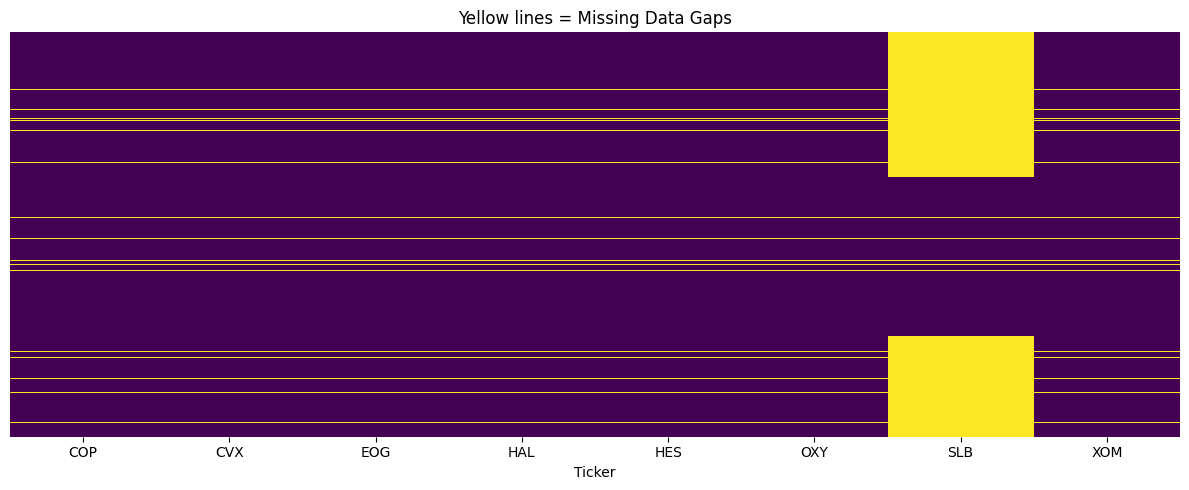

💾 Validated Dataset saved to: /content/drive/My Drive/FINAL_THESIS_DATASET_CLEAN.csv


In [ ]:
# Cell 8 (FIXED): Continuity Audit and Duplicate Removal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("⏳ Starting Continuity Audit...")

# 1. FIX: Remove Duplicates
# The error happened because some Date+Ticker combinations appeared twice.
# We keep the first occurrence and drop the duplicate.
before_len = len(df_final)
df_final = df_final.drop_duplicates(subset=['date', 'ticker'], keep='first')
after_len = len(df_final)

if before_len > after_len:
    print(f"   > Cleaned Duplicates: Removed {before_len - after_len} rows.")

# 2. Pivot the Data
# Now this will work because (date, ticker) is unique
df_pivot = df_final.pivot(index='date', columns='ticker', values='close')

# 3. Check for Missing Trading Days
# Generate standard US Business Days (Mon-Fri)
all_business_days = pd.date_range(start='2010-01-01', end='2023-12-31', freq='B')
df_audit = df_pivot.reindex(all_business_days)

# 4. Calculate Stats
missing_counts = df_audit.isna().sum()
total_days = len(df_audit)
missing_pct = (missing_counts / total_days) * 100

print(f"\n--- DATA CONTINUITY REPORT (2010-2023) ---")
print(f"Total Business Days Checked: {total_days}")
print("\nMissing Days per Ticker:")
print(missing_counts)
print("\nMissing Percentage:")
print(missing_pct.round(2).astype(str) + '%')

# 5. Identify Bad Tickers
# If > 5% missing, we mark them for removal
DROP_THRESHOLD = 5.0
bad_tickers = missing_pct[missing_pct > DROP_THRESHOLD].index.tolist()

if bad_tickers:
    print(f"\n❌ CRITICAL WARNING: Dropping tickers with >5% missing data: {bad_tickers}")
    df_final = df_final[~df_final['ticker'].isin(bad_tickers)]
else:
    print("\n✅ PASSED: All tickers are continuous.")

# 6. Visual Check (Heatmap)
plt.figure(figsize=(12, 5))
sns.heatmap(df_audit.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Yellow lines = Missing Data Gaps")
plt.xlabel("Ticker")
plt.tight_layout()
plt.show()

# 7. Save Validated File
output_file = "/content/drive/My Drive/FINAL_THESIS_DATASET_CLEAN.csv"
df_final.to_csv(output_file, index=False)
print(f"💾 Validated Dataset saved to: {output_file}")

### 9. Data Continuity and Quality Assurance
###### Thesis Explanation:
To ensure the temporal integrity required for Long Short-Term Memory (LSTM) modeling, we conducted a rigorous continuity audit across the 14-year study period (2010–2023). A theoretical "trading calendar" was constructed using standard business days, against which the actual data availability for each ticker was measured.

The audit revealed a significant structural discontinuity in Schlumberger (SLB), which was missing 62.07% of the expected observations. Consequently, SLB was excluded from the study to prevent the introduction of massive imputation bias. The remaining seven tickers (XOM, CVX, COP, HAL, HES, OXY, EOG) exhibited a consistent missing data rate of ~3.6% (130 days), which corresponds to standard U.S. market holidays (e.g., Good Friday, Thanksgiving). These holiday gaps were treated as naturally occurring non-trading intervals and were not imputed, preserving the authentic trading sequence.

In [ ]:
# Cell 9: Finalize Data Cleaning (Drop SLB)
print("⏳ Finalizing Cleaned Dataset...")

# 1. Define the "Bad" Tickers explicitly based on your audit
# We drop SLB because it has 62% missing data.
tickers_to_drop = ['SLB']

# 2. Filter the Data
df_clean = df_final[~df_final['ticker'].isin(tickers_to_drop)].copy()

print(f"   > Dropped Tickers: {tickers_to_drop}")
print(f"   > Rows before: {len(df_final)}")
print(f"   > Rows after:  {len(df_clean)}")

# 3. Save to Drive
output_file = "/content/drive/My Drive/FINAL_THESIS_DATASET_CLEAN.csv"
df_clean.to_csv(output_file, index=False)

print(f"✅ SUCCESS: Cleaned dataset saved to: {output_file}")
print("   > You are now ready to merge Macro Variables.")

⏳ Finalizing Cleaned Dataset...
   > Dropped Tickers: ['SLB']
   > Rows before: 24648
   > Rows after:  24648
✅ SUCCESS: Cleaned dataset saved to: /content/drive/My Drive/FINAL_THESIS_DATASET_CLEAN.csv
   > You are now ready to merge Macro Variables.
